# Dfsu - 3D sigma-z
This notebook demonstrates, reading from a sigma-z dfsu file, top- and bottom layers, extracting a profile, save selected layers to new dfsu file and save to mesh. 

It also shows how to read a sigma-z vertical slice file. 

In [1]:
import mikeio

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('png')

In [2]:
filename = "../tests/testdata/oresund_sigma_z.dfsu"
dfs = mikeio.open(filename)
dfs

Dfsu3DSigmaZ
number of elements: 17118
number of nodes: 12042
projection: UTM-33
number of sigma layers: 4
max number of z layers: 5
items:
  0:  Temperature <Temperature> (degree Celsius)
  1:  Salinity <Salinity> (PSU)
time: 3 steps with dt=10800.0s
      1997-09-15 21:00:00 -- 1997-09-16 03:00:00

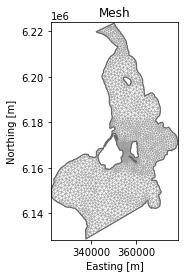

In [3]:
dfs.geometry.plot.mesh();

## Save geometry to new mesh file
Note that for sigma-z files, the mesh will be not match the original mesh in areas where z-layers are present! 

In [4]:
outmesh = "mesh_oresund_extracted.mesh"
dfs.to_mesh(outmesh)

## Evaluate top layer

In [5]:
ds = dfs.read(layers="top")
print(ds)
max_t = ds['Temperature'].to_numpy().max()
print(f'Maximum temperature in top layer: {max_t:.1f}')

<mikeio.Dataset>
dims: (time:3, element:3700)
time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00 (3 records)
geometry: Dfsu2D (3700 elements, 2090 nodes)
items:
  0:  Temperature <Temperature> (degree Celsius)
  1:  Salinity <Salinity> (PSU)
Maximum temperature in top layer: 17.5


## Find position of max temperature and plot

Find position of max temperature in first time step 

In [6]:
timestep = 0
elem = ds['Temperature'][timestep].to_numpy().argmax()
max_x, max_y = ds.geometry.element_coordinates[elem,:2]
print(f'Position of maximum temperature: (x,y) = ({max_x:.1f}, {max_y:.1f})')

Position of maximum temperature: (x,y) = (333934.1, 6158101.5)


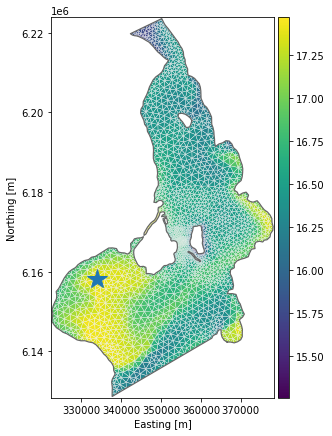

In [7]:
ax = dfs.plot(z=ds['Temperature'][timestep], figsize=(6,7))
ax.plot(max_x, max_y, marker='*', markersize=20);

# Read 1D profile from 3D file
Find water column which has highest temperature and plot profile for all 3 time steps.

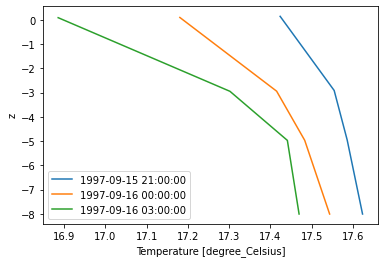

In [8]:
dsp = dfs.read(x=max_x, y=max_y) # select vertical column from dfsu-3d 
dsp["Temperature"].plot();

Note that the vertical column data is extrapolated to the bottom and surface! 

The extrapolation can avoided using "extrapolate=False":

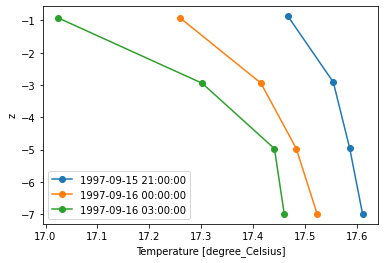

In [9]:
dsp["Temperature"].plot(extrapolate=False, marker='o');

If the data has more than a few timesteps, it can be more convenient to plot as 2d pcolormesh. We will simulate this by interpolating to 30min data. 

Note that pcolormesh will plot using the static z information!

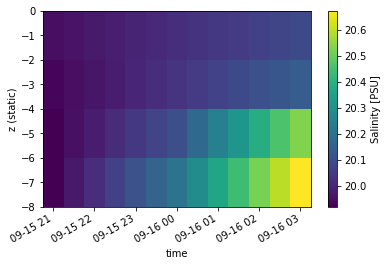

In [10]:
dspi = dsp.Salinity.interp_time(dt=1800)
dspi.plot.pcolormesh();

# Read top layer of a smaller area

In [11]:
bbox = [310000, 6192000, 380000, 6198000]
ds_sub = dfs.read(area=bbox, layers="top")
ds_sub

<mikeio.Dataset>
dims: (time:3, element:118)
time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00 (3 records)
geometry: Dfsu2D (118 elements, 87 nodes)
items:
  0:  Temperature <Temperature> (degree Celsius)
  1:  Salinity <Salinity> (PSU)

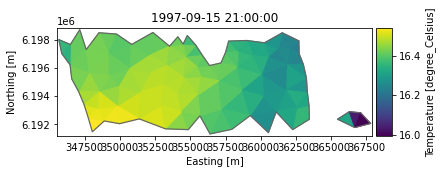

In [12]:
ds_sub.Temperature.plot();

Plot subset inside original model domain

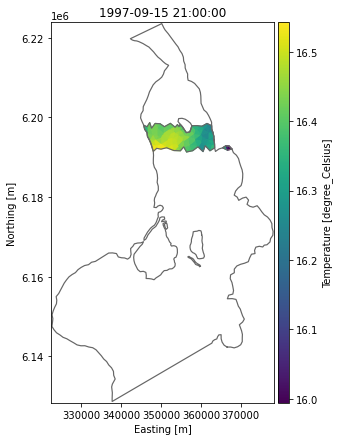

In [13]:
ax = ds_sub.Temperature.plot(figsize=(6,7))
dfs.geometry.plot.outline(ax=ax, title=None);

In [14]:
ds_sub.to_dfs("oresund_data_extracted.dfsu")

# Select top 2 layers and write to new file
get_layer_elements() can take a list of layers. Layers are counted positive from the bottom starting at 0 or alternatively counted negative from the top starting at -1. Here we take layers -1 and -2, i.e., the two top layers. 

Next data is read from source file and finally written to a new dfsu file (which is now sigma-only dfsu file).

In [15]:
ds_top2 = dfs.read(layers=[-2, -1])
ds_top2

<mikeio.Dataset>
dims: (time:3, element:7400)
time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00 (3 records)
geometry: Dfsu3DSigma (7400 elements, 2 sigma-layers, 0 z-layers)
items:
  0:  Temperature <Temperature> (degree Celsius)
  1:  Salinity <Salinity> (PSU)

In [16]:
outfile = "oresund_top2_layers.dfsu"
ds_top2.to_dfs(outfile)

# Read vertical slice (transect)

In [17]:
filename = "../tests/testdata/oresund_vertical_slice.dfsu"
ds = mikeio.read(filename)
ds

<mikeio.Dataset>
dims: (time:3, element:441)
time: 1997-09-15 21:00:00 - 1997-09-16 03:00:00 (3 records)
geometry: DfsuVerticalProfileSigmaZ (441 elements, 4 sigma-layers, 5 z-layers)
items:
  0:  Temperature <Temperature> (degree Celsius)
  1:  Salinity <Salinity> (PSU)

In [18]:
print(ds.geometry.bottom_elements[:9])
print(ds.geometry.n_layers_per_column[:9])
print(ds.geometry.top_elements[:9])

[ 0  5 10 15 20 24 28 32 36]
[5 5 5 5 4 4 4 4 4]
[ 4  9 14 19 23 27 31 35 39]


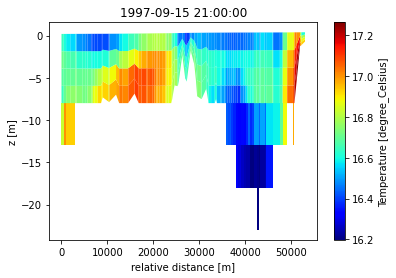

In [21]:
ds.Temperature.plot();

# Clean up

In [19]:
import os
os.remove("mesh_oresund_extracted.mesh")
os.remove("oresund_data_extracted.dfsu")
os.remove("oresund_top2_layers.dfsu")